
# Introduction

## Background Discussion

The Economist Intelligence Unit's (EIU) ["Global Liveability Report"](https://www.eiu.com/n/) ranks the best places to live in the world, scoring 140 cities in five categories: 

1. stability, 
2. healthcare, 
3. culture & environment, 
4. education, and 
5. infrastructure. 

In the article called ["These Are the 10 Best Places to Live in the World"](https://www.cntraveler.com/gallery/the-most-livable-cities-in-the-world) updated on *April 23, 2020* the author, Cailin Morton, uses the EIU ranking to identify top 10 places to live in the world.

According to the artice \#1 city to live in is Vienna (Austria):

Maintaining its position in the number one spot for the second year in a row, Vienna provides the perfect blend of adventure, affordability, ease of living, and safety. The Austrian capital draws crowds with its Baroque architecture and Danube cruises, but it's just as exciting as a center of what’s new in the culinary and art worlds of Europe. And due to a city government that puts a lot of resources behind infrastructure and housing, the cost of living here is far lower than comparable European cities.

**Overall rating: 99.1**
- Stability: 100
- Healthcare: 100
- Culture & Environment: 96.3
- Education: 100
- Infrastructure: 100

## Problem Description

Since Vienna is considered to be the best place to live many people are interested in moving to Vienna either permanently or temporarily. So in this project we will help people who want to be looking for renting apartment in Vienna. They will be able to see:

- How districs compare in prices for rent (where is more expensive, where is less)
- Compare districs by their type (either commercial or residential)

Additionaly, for those who already live in Vienna they will be able to see:

- If they're paying above or below average market price for their apartment
- If there are similar districts to theirs with lower rent prices


## Data Description & Methodology

For this project we will be using the following data:

- **apartments in Vienna** *(size, number of rooms, address, and price):* using BeutifulSoup library to scrap a [local website](https://www.willhaben.at/iad) with apartment listings
- **coordinates for districts:** using geopy to get location data for all Vienna's districs
- **infomation on closest venues:** using Foursquare API to collect the closest venues like supermarket, restaurant, park, etc.

We will apply various data manipulation techniques to clean and prepare the data for analysis and use various data visualization tools to compare districts.

Then we will run k-means clustering to partition districts into residential and commercial areas and visualize all the data on a single choropleth map.

## Load libraries

In [1]:
# Import libraries
import numpy as np # to handle data in a vectorized manner
import pandas as pd # for data manipulation and analysis

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import great_circle

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge beautifulsoup4 bs4 --yes
from bs4 import BeautifulSoup # web-scraping

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # library to handle requests
from requests import get

#!conda install -c conda-forge beautifulsoup4 bs4 --yes # uncomment this line if you haven't completed the Foursquare API lab
from bs4 import BeautifulSoup # web-scraping

import re # regular expessions operations

from time import sleep

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

from sklearn.cluster import KMeans # Import k-means from clustering stage

print('Libraries imported.')

Libraries imported.


## 1. Web-scraping using BeutifulSoup for apartments listing in Vienna from WILLHABEN website

Loop through all of the pages to extract the following data from all of the listings:

- Postal Code, 
- District, 
- Size (m2), 
- Number of rooms, 
- Price

In [2]:
listing_found = True
page_num = 1
listings = []

while listing_found:
    
    # define header to make the request look like it's comming from an actual browser
    headers = {'User-agent': 'Googlebot'}
    
    # set url 
    url = 'https://www.willhaben.at/iad/immobilien/mietwohnungen/mietwohnung-angebote?areaId=900&page={}&rows=200'.format(page_num)
    
    # load the response
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # find all outer containers of listings
    apartment_containers = soup.find_all('section', class_="content-section isRealestate")
    
    # check if page contains listings
    if len(apartment_containers) == 0:
        break
    
    # for each apartment extract relevant data
    for apt in apartment_containers:
        try:
            info = apt.find_all('div', class_="info")[0]

            try:
                size = info.find_all('span', class_="desc-left")[0].text.split()[0]
            except:
                size = np.nan

            try:
                rooms = info.find_all('span', class_="desc-left")[0].text.split()[2]
            except:
                rooms = np.nan

            try:
                price = info.find_all('span', class_="pull-right")[0].text.split()[0]
            except:
                price = np.nan

        except:
            size, rooms, price = np.nan

        try:
            full_address = apt.find_all('div', class_="address-lg w-brk-ln-1")[0].text.split()
            full_address = ' '.join(full_address)

            postal_code = re.search('1\d\d0', full_address)[0]
            district = full_address.split(', ')[-1]

            if address == None:
                address = None
            else:
                address = address[1]

                if len(address.split(', ')) > 1:
                    address = address.split(', ')[0]
        except:
            address = None
            postal_code = None
            district = None

        listings.append([postal_code, district, size, rooms, price])
    
    # increase page number
    page_num += 1
    
    # set sleep to mimic a more human behaviour and don't overload the site with requests
    sleep(np.random.randint(1,3))

**Create a dataframe with the data from listings**

In [3]:
column_names = ['PostalCode', 'District', 'Size', 'Rooms', 'Price']
rental_properties = pd.DataFrame(listings, columns=column_names)

In [4]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 9796 apartments in the dataset


In [5]:
rental_properties.head()

,PostalCode,District,Size,Rooms,Price
0,None,None,85,3,"1.322,78"
1,1050,Margareten,132,5,"1.680,-"
2,1140,Penzing,33,1,"615,-"
3,1190,Döbling,50,1,"850,-"
4,1120,Meidling,66,2,"928,69"


## 2.1. Cleaning and Pre-processing of data

**Check data types and correct if necessary**

In [6]:
rental_properties.dtypes

PostalCode    object
District      object
Size          object
Rooms         object
Price         object
dtype: object

In [7]:
# clean/correct column 'Size'
rental_properties['Size'] = rental_properties['Size'].str.replace('–', 'NaN').astype('float')

In [8]:
# clean/correct column 'Rooms'
rental_properties['Rooms'] = rental_properties['Rooms'].astype('float')

In [9]:
# clean/correct column 'Price'
rental_properties['Price'] = rental_properties['Price'].str.replace('.', '').str.replace(',', '.').str.replace('-', '00').str.replace('vermietet', 'NaN').str.replace('verkauft', 'NaN').astype('float')

In [10]:
# check data in 'PostalCode' column
rental_properties.PostalCode.unique()

array([None, '1050', '1140', '1190', '1120', '1020', '1220', '1090',
       '1210', '1060', '1010', '1110', '1100', '1200', '1130', '1030',
       '1230', '1040', '1080', '1070', '1150', '1160', '1170', '1180'],
      dtype=object)

In [11]:
rental_properties.dtypes

PostalCode     object
District       object
Size          float64
Rooms         float64
Price         float64
dtype: object

**Create a calculated column 'Price/m2'**

In [12]:
rental_properties['Price/m2'] = (rental_properties['Price']/rental_properties['Size']).round(2)

In [13]:
rental_properties.head()

,PostalCode,District,Size,Rooms,Price,Price/m2
0,None,None,85.0,3.0,1322.78,15.56
1,1050,Margareten,132.0,5.0,1680.00,12.73
2,1140,Penzing,33.0,1.0,615.00,18.64
3,1190,Döbling,50.0,1.0,850.00,17.00
4,1120,Meidling,66.0,2.0,928.69,14.07


In [14]:
# check datatypes onces again to be sure there're correct
rental_properties.dtypes

PostalCode     object
District       object
Size          float64
Rooms         float64
Price         float64
Price/m2      float64
dtype: object

**View descriptive statistics and deal will missing values**

In [15]:
rental_properties.describe()

,Size,Rooms,Price,Price/m2
count,9774.000000,9096.000000,9762.000000,9756.000000
mean,82.081338,2.690303,1333.852115,16.965096
std,44.598398,3.442620,2962.012907,45.242486
min,1.000000,1.000000,30.000000,0.670000
25%,52.000000,2.000000,799.000000,13.410000
50%,70.000000,2.000000,999.000000,15.500000
75%,99.000000,3.000000,1528.975000,17.710000
max,664.000000,312.000000,280000.000000,4179.100000


In [16]:
# Remove rows with no data in all columns except 'Rooms' since it has too many missing values
rental_properties.dropna(subset=['PostalCode', 'District', 'Size', 'Price'], inplace=True)

In [17]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 9753 apartments in the dataset


**Check how many apartments per 'Room' number is the dataset**

In [18]:
rental_properties['Rooms'].value_counts()

2.0      3896
3.0      2810
4.0      1204
1.0       758
5.0       269
6.0        81
7.0        48
8.0         6
9.0         2
312.0       1
23.0        1
45.0        1
11.0        1
Name: Rooms, dtype: int64

**99.9% of apartments have <= 5 rooms - usually larger apartments are considered luxury and therefore can be excluded from the dataset**

In [19]:
rental_properties = rental_properties[rental_properties['Rooms'] <= 5]

In [20]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 8937 apartments in the dataset


## 2.2. Data Visualization

**How many apartments per room number and per disctrict are there?**

[Text(0, 0, '1010'),
 Text(0, 0, '1020'),
 Text(0, 0, '1030'),
 Text(0, 0, '1040'),
 Text(0, 0, '1050'),
 Text(0, 0, '1060'),
 Text(0, 0, '1070'),
 Text(0, 0, '1080'),
 Text(0, 0, '1090'),
 Text(0, 0, '1100'),
 Text(0, 0, '1110'),
 Text(0, 0, '1120'),
 Text(0, 0, '1130'),
 Text(0, 0, '1140'),
 Text(0, 0, '1150'),
 Text(0, 0, '1160'),
 Text(0, 0, '1170'),
 Text(0, 0, '1180'),
 Text(0, 0, '1190'),
 Text(0, 0, '1200'),
 Text(0, 0, '1210'),
 Text(0, 0, '1220'),
 Text(0, 0, '1230')]

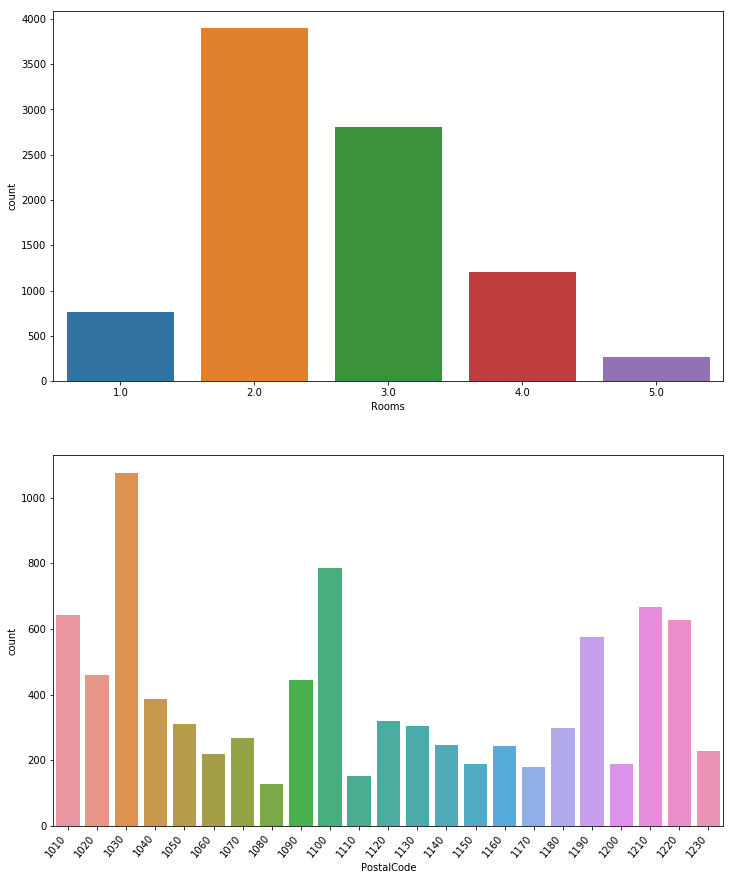

In [21]:
fig, ax = plt.subplots(2,1, figsize=(12,15))
sns.countplot(rental_properties['Rooms'], ax=ax[0])
sns.countplot(rental_properties['PostalCode'], ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=50, ha="right")

**Plot prices and check for outliers in the dataset**

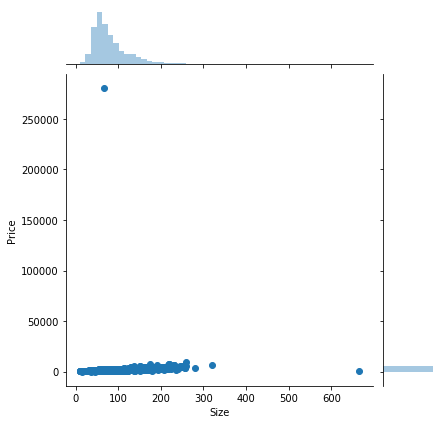

In [22]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

**Remove outliers for Price**

In [23]:
rental_properties = rental_properties[rental_properties['Price'] <= 9000]

**Remove outliers for Size**

In [24]:
rental_properties = rental_properties[rental_properties['Size'] <= 400]

In [25]:
print('There are {} apartments in the dataset'.format(rental_properties.shape[0]))

There are 8934 apartments in the dataset


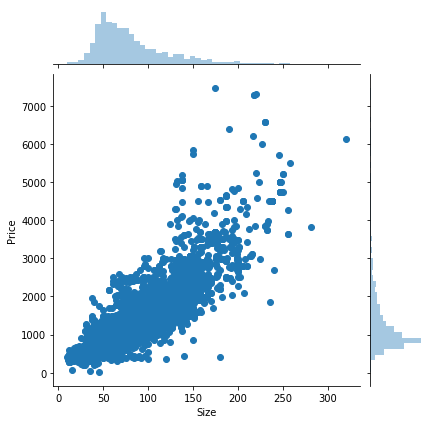

In [26]:
sns.jointplot(x='Size', y='Price', data=rental_properties[['Size','Price']])

**Intuitively the price should be in direct proportion to the number of rooms. Build a box plot to analyze this relationship**

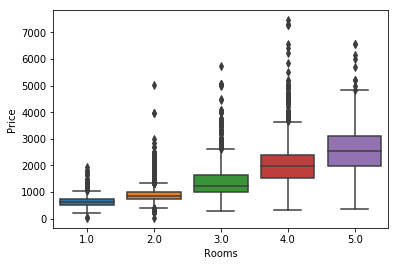

In [27]:
sns.boxplot(x='Rooms', y='Price', data=rental_properties)

**Box plot confirmed our intuition. It also shows that price range for 1-room apartments is very close to 2-room apartments**

**Now when it comes to price/m2 we expect to see the inverse proportion**

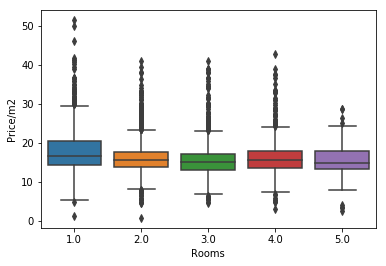

In [28]:
sns.boxplot(x='Rooms', y='Price/m2', data=rental_properties)

**It turns out the proportion is not as strong as expected. Yet we did confirm that 1-room apartments are more expensive per m2 than apartments with more rooms**

**What about the distribution of price/m2 in districs?**

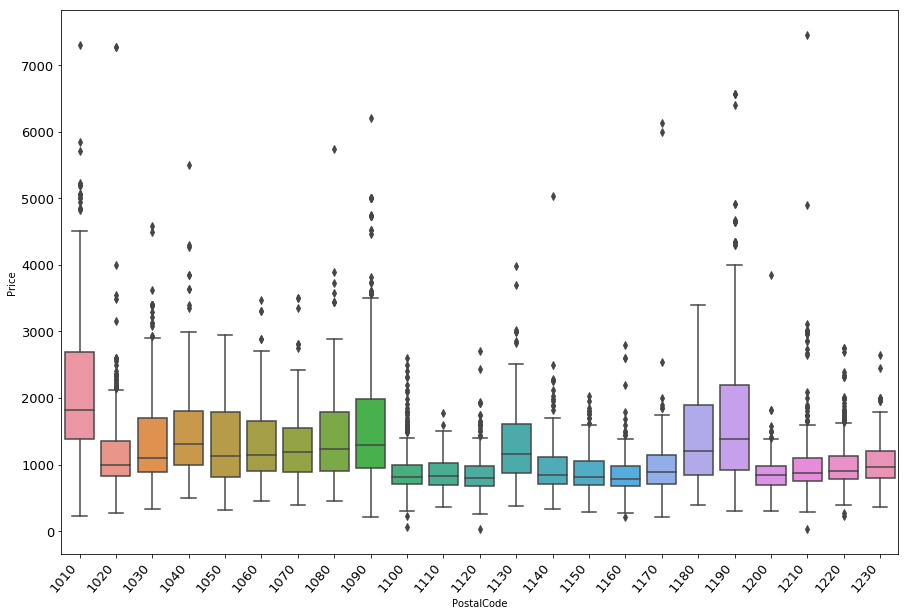

In [29]:
plt.figure(figsize=(15,10))
ax = sns.boxplot(x='PostalCode', y='Price', data=rental_properties)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.tick_params(labelsize=13)

**1010 (Innere Stadt) seem to be the most expensive district folloed by 1190 (Döbling) and then by 1090 (Alsergrund) and 1180 (Währing).**

**We can keep it in mind for the further analysis**

In [30]:
# Save the dataframe to a csv file (optional)
rental_properties.to_csv('districts_vienna.csv', index=False)

## 3. Get coordinates for each district and visualize them on the map

**First, get unique districts from the dataset**

In [31]:
vienna_districts = rental_properties[['PostalCode','District']].drop_duplicates().sort_values(by=['PostalCode']).reset_index(drop=True)
vienna_districts

,PostalCode,District
0,1010,Innere Stadt
1,1020,Leopoldstadt
2,1030,Landstraße
3,1040,Wieden
4,1050,Margareten
5,1060,Mariahilf
6,1070,Neubau
7,1080,Josefstadt
8,1090,Alsergrund
9,1100,Favoriten


In [34]:
latitude = np.zeros(vienna_districts.shape[0])
longitude = np.zeros(vienna_districts.shape[0])

geolocator = Nominatim(user_agent="vienna_explorer")

for idx in range(vienna_districts.shape[0]):
    address = vienna_districts['District'].loc[idx] + ', Wien'
    
    location = geolocator.geocode(address)
    latitude[idx] = location.latitude
    longitude[idx] = location.longitude

In [35]:
district_coordinates = vienna_districts
district_coordinates['Latitude'] = latitude
district_coordinates['Longitude'] = longitude
district_coordinates

,PostalCode,District,Latitude,Longitude
0,1010,Innere Stadt,48.209023,16.369851
1,1020,Leopoldstadt,48.200638,16.426895
2,1030,Landstraße,48.193644,16.396286
3,1040,Wieden,48.208354,16.372504
4,1050,Margareten,48.188073,16.353386
5,1060,Mariahilf,48.195475,16.347023
6,1070,Neubau,48.202264,16.349123
7,1080,Josefstadt,48.210852,16.347360
8,1090,Alsergrund,48.225073,16.358398
9,1100,Favoriten,48.152994,16.382822


In [36]:
address_vienna = 'Vienna'

geolocator = Nominatim(user_agent="vienna_explorer")

location_vienna = geolocator.geocode(address_vienna)
latitude_vienna = location_vienna.latitude
longitude_vienna = location_vienna.longitude

print('The geographical coordinates of Vienna (Austria) are {}, {}.'.format(latitude_vienna, longitude_vienna))

The geographical coordinates of Vienna (Austria) are 48.2083537, 16.3725042.


**Visualize districts on the map**

In [37]:
# create map of Vienna using latitude and longitude values

map_vienna = folium.Map(location=[latitude_vienna, longitude_vienna], zoom_start=12, width = 1000, height = 1500)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vienna)  
    
map_vienna

## 4. Use choropleth map to visualize averages of price, price/m2 and apartment size per district

**Extract Vienna districts from the [JSON file](https://github.com/ginseng666/GeoJSON-TopoJSON-Austria) and edit the keys to match our data**

In [38]:
import urllib.request

url='https://raw.githubusercontent.com/EkaterinaBubenko/ds-capstone/master/gemeinden_wien_bezirke_geo.json'
json_data = urllib.request.urlopen(url).read().decode('utf-8')
location_json = json.loads(json_data)

In [39]:
location_json

{'type': 'FeatureCollection',
 'crs': {'type': 'name',
  'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}},
 'features': [{'type': 'Feature',
   'properties': {'iso': 90301, 'name': 'Wien Landstraße'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[16.432300780145614, 48.18683376529176],
       [16.396648121000403, 48.17601779687461],
       [16.382187879750663, 48.18860649891967],
       [16.376409477879744, 48.20044506982437],
       [16.386098562683255, 48.21184913159717],
       [16.432300780145614, 48.18683376529176]]]]}},
  {'type': 'Feature',
   'properties': {'iso': 90801, 'name': 'Wien Josefstadt'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[16.357707145177447, 48.214838731648975],
       [16.35707306532471, 48.207406755652094],
       [16.33963891897216, 48.209079724215655],
       [16.340452820890295, 48.21264418079829],
       [16.34207281507504, 48.21567161014388],
       [16.357707145177447, 48.214838731648975]]]]}},
  {'type': '

In [41]:
# prep district name
for idx in range(len(location_json['features'])):
    location_json['features'][idx]['properties']['name'] = location_json['features'][idx]['properties']['name'].replace('Wien ','')

In [46]:
location_json['features'] = location_json['features'][:23]

**Calculate the mean per district**

In [42]:
mean_per_district = rental_properties.groupby('District').mean().reset_index()
mean_per_district

,District,Size,Rooms,Price,Price/m2
0,Alsergrund,95.275395,2.753950,1604.019436,17.095508
1,Brigittenau,65.962766,2.260638,880.854096,13.892234
2,Donaustadt,63.498403,2.351438,987.946038,16.125431
3,Döbling,97.583624,2.939024,1695.963885,17.003868
4,Favoriten,59.080051,2.298602,883.669238,15.519911
5,Floridsdorf,67.367316,2.497751,968.244543,14.675247
6,Hernals,70.240223,2.418994,1001.562793,14.432235
7,Hietzing,87.277228,2.712871,1308.495974,15.295710
8,Innere Stadt,108.710280,2.822430,2140.113489,19.997072
9,Josefstadt,92.914062,2.765625,1455.362031,15.725937


## 4.1. Average price per district

In [47]:
# create a plain map of Vienna
vienna_map = folium.Map(location=[latitude_vienna, longitude_vienna], zoom_start=12, width = 1500, height = 1000)

# add the data
vienna_map.choropleth(
    geo_data=location_json,
    data=mean_per_district,
    columns=['District', 'Price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price for each district in Vienna'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map) 

# display map
vienna_map

## 4.2. Average price/m2 per district

**Since in the dataset we have apartments with various room numbers the best way to compare prices is using relative price/m2**

In [49]:
# create a plain map of Vienna
vienna_map = folium.Map(location=[latitude_vienna, longitude_vienna], zoom_start=12, width = 1500, height = 1000)

# add the data
vienna_map.choropleth(
    geo_data=location_json,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Vienna'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map) 

# display map
vienna_map

## 4.3. Average apartment size per district

In [50]:
# create a plain map of Vienna
vienna_map = folium.Map(location=[latitude_vienna, longitude_vienna], zoom_start=12, width = 1500, height = 1000)

# add the data
vienna_map.choropleth(
    geo_data=location_json,
    data=mean_per_district,
    columns=['District', 'Size'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average apartment size for each district in Vienna'
)

# add markers to map
for lat, lng, postalcode, district in zip(district_coordinates['Latitude'], district_coordinates['Longitude'], district_coordinates['PostalCode'], district_coordinates['District']):
    dist = postalcode[1:3]
    label = '{}. {}'.format(dist, district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(vienna_map) 

# display map
vienna_map

## 5. Get Foursquare API data

**Define Foursquare Credentials and Version**

In [51]:
# The code was removed by Watson Studio for sharing.

**Function for collecting information about venues for all districts in Vienna**

In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [53]:
vienna_venues = getNearbyVenues(names=district_coordinates['District'],
                                latitudes=district_coordinates['Latitude'],
                                longitudes=district_coordinates['Longitude'],
                                radius=2000, LIMIT=100)

In [54]:
vienna_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.209023,16.369851,Stephansplatz,48.208299,16.371880,Plaza
1,Innere Stadt,48.209023,16.369851,Stephansdom,48.208626,16.372672,Church
2,Innere Stadt,48.209023,16.369851,Michaelerplatz,48.208007,16.366625,Plaza
3,Innere Stadt,48.209023,16.369851,Graben,48.208915,16.369379,Pedestrian Plaza
4,Innere Stadt,48.209023,16.369851,Park Hyatt Vienna,48.210691,16.367788,Hotel


In [55]:
print('{} venues are collected'.format(vienna_venues.shape[0]))

1683 venues are collected


In [56]:
vienna_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Alsergrund,100,100,100,100,100,100
Brigittenau,100,100,100,100,100,100
Donaustadt,31,31,31,31,31,31
Döbling,66,66,66,66,66,66
Favoriten,51,51,51,51,51,51
Floridsdorf,55,55,55,55,55,55
Hernals,30,30,30,30,30,30
Hietzing,25,25,25,25,25,25
Innere Stadt,100,100,100,100,100,100


**Identify number of unique categories of venues**

In [57]:
print('There are {} uniques categories.'.format(len(vienna_venues['Venue Category'].unique())))

There are 214 uniques categories.


## 6. Analyze Each District

In [58]:
# one hot encoding
vienna_onehot = pd.get_dummies(vienna_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vienna_onehot['District'] = vienna_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [vienna_onehot.columns[-1]] + list(vienna_onehot.columns[:-1])
vienna_onehot = vienna_onehot[fixed_columns]

vienna_onehot.head()

,District,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,...,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo Exhibit
0,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Innere Stadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Group rows by district and by the mean of the frequency of occurrence of each category**

In [59]:
vienna_grouped = vienna_onehot.groupby('District').mean().reset_index()
vienna_grouped

,District,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Austrian Restaurant,Auto Garage,...,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Winery,Yoga Studio,Zoo Exhibit
0,Alsergrund,0.00,0.00,0.00,0.00,0.00,0.010000,0.000000,0.030000,0.000000,...,0.010000,0.000000,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,Brigittenau,0.00,0.00,0.00,0.00,0.00,0.020000,0.000000,0.050000,0.000000,...,0.010000,0.010000,0.00,0.00,0.000000,0.000000,0.010000,0.020000,0.00,0.000000
2,Donaustadt,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,Döbling,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.121212,0.000000,...,0.000000,0.000000,0.00,0.00,0.015152,0.075758,0.000000,0.000000,0.00,0.015152
4,Favoriten,0.00,0.00,0.00,0.00,0.00,0.000000,0.039216,0.098039,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,Floridsdorf,0.00,0.00,0.00,0.00,0.00,0.018182,0.018182,0.036364,0.000000,...,0.000000,0.000000,0.00,0.00,0.018182,0.018182,0.018182,0.000000,0.00,0.000000
6,Hernals,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.166667,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
7,Hietzing,0.00,0.00,0.00,0.00,0.00,0.040000,0.000000,0.040000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
8,Innere Stadt,0.01,0.00,0.00,0.03,0.00,0.000000,0.000000,0.080000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,0.010000,0.000000,0.000000,0.00,0.000000
9,Josefstadt,0.01,0.01,0.01,0.02,0.00,0.020000,0.000000,0.010000,0.000000,...,0.010000,0.000000,0.00,0.01,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


**Function to sort venues in descending order**

In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

**Create a new dataframe and display the top 10 venues for each district**

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = vienna_grouped['District']

for idx in np.arange(vienna_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = return_most_common_venues(vienna_grouped.iloc[idx, :], num_top_venues)

In [62]:
district_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alsergrund,Restaurant,Café,Park,Hotel,Tapas Restaurant,Cocktail Bar,Coffee Shop,Italian Restaurant,Austrian Restaurant,Plaza
1,Brigittenau,Supermarket,Plaza,Park,Austrian Restaurant,Italian Restaurant,Ice Cream Shop,Kebab Restaurant,Restaurant,Bakery,Gym / Fitness Center
2,Donaustadt,Bus Stop,Supermarket,Fast Food Restaurant,Metro Station,Gastropub,Lake,Japanese Restaurant,Soccer Field,Pizza Place,Garden Center
3,Döbling,Austrian Restaurant,Café,Restaurant,Wine Bar,Bus Stop,Italian Restaurant,Scenic Lookout,Cosmetics Shop,Fast Food Restaurant,Bakery
4,Favoriten,Supermarket,Austrian Restaurant,Grocery Store,Soccer Field,Train Station,Metro Station,Café,Food & Drink Shop,Park,Playground
5,Floridsdorf,Supermarket,Light Rail Station,Fast Food Restaurant,Café,Shopping Mall,Austrian Restaurant,Tram Station,Restaurant,Grocery Store,Gym / Fitness Center
6,Hernals,Austrian Restaurant,Bus Stop,Pool,Tram Station,Park,Bakery,Italian Restaurant,Gastropub,Climbing Gym,Gluten-free Restaurant
7,Hietzing,Park,Supermarket,Hotel,Italian Restaurant,Bakery,Scenic Lookout,Hostel,Historic Site,Gastropub,Food
8,Innere Stadt,Hotel,Plaza,Austrian Restaurant,Café,Ice Cream Shop,Restaurant,Park,Art Museum,Japanese Restaurant,Coffee Shop
9,Josefstadt,Coffee Shop,Plaza,Park,Hotel,Ice Cream Shop,Tapas Restaurant,Italian Restaurant,Café,Pizza Place,Gym


## 7. Cluster districts

**Elbow Curve to find optimum number of clusters**

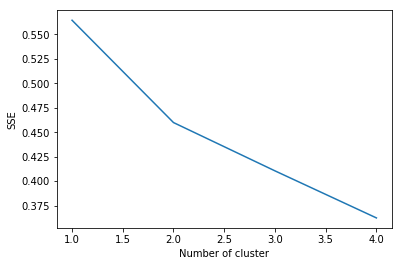

In [63]:
vienna_grouped_clustering = vienna_grouped.drop('District', 1)
sse={}
for k in range(1, 5):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(vienna_grouped_clustering)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

**It appears that the optimum number of clusters is 2**

In [64]:
# set number of clusters
kclusters = 2

vienna_grouped_clustering = vienna_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vienna_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 0], dtype=int32)

**Create a new dataframe that includes the cluster as well as the price/m2 and the top 10 venues for each neighborhood**

In [65]:
# add clustering labels
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# add price/m2 for each district
vienna_merged = pd.merge(district_coordinates, mean_per_district[['District', 'Price/m2']])

# add latitude/longitude for each district
vienna_merged = vienna_merged.join(district_venues_sorted.set_index('District'), on='District')

vienna_merged

,PostalCode,District,Latitude,Longitude,Price/m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1010,Innere Stadt,48.209023,16.369851,19.997072,0,Hotel,Plaza,Austrian Restaurant,Café,Ice Cream Shop,Restaurant,Park,Art Museum,Japanese Restaurant,Coffee Shop
1,1020,Leopoldstadt,48.200638,16.426895,16.161326,1,Restaurant,Supermarket,Hotel,Café,Metro Station,Gym / Fitness Center,Italian Restaurant,Seafood Restaurant,Asian Restaurant,Austrian Restaurant
2,1030,Landstraße,48.193644,16.396286,16.708679,0,Hotel,Restaurant,Austrian Restaurant,Concert Hall,Café,Italian Restaurant,Asian Restaurant,Grocery Store,Bakery,Gastropub
3,1040,Wieden,48.208354,16.372504,15.984304,0,Plaza,Hotel,Austrian Restaurant,Ice Cream Shop,Café,Restaurant,Park,Concert Hall,Art Museum,French Restaurant
4,1050,Margareten,48.188073,16.353386,15.478673,0,Austrian Restaurant,Hotel,Plaza,Ice Cream Shop,Coffee Shop,Restaurant,Pizza Place,Burger Joint,Indian Restaurant,Japanese Restaurant
5,1060,Mariahilf,48.195475,16.347023,15.941096,0,Hotel,Ice Cream Shop,Austrian Restaurant,Plaza,Coffee Shop,Pizza Place,Restaurant,Gastropub,Gym,Hostel
6,1070,Neubau,48.202264,16.349123,15.808364,0,Hotel,Plaza,Ice Cream Shop,Coffee Shop,Pizza Place,Austrian Restaurant,Park,Art Museum,Gym,Tapas Restaurant
7,1080,Josefstadt,48.210852,16.347360,15.725937,0,Coffee Shop,Plaza,Park,Hotel,Ice Cream Shop,Tapas Restaurant,Italian Restaurant,Café,Pizza Place,Gym
8,1090,Alsergrund,48.225073,16.358398,17.095508,0,Restaurant,Café,Park,Hotel,Tapas Restaurant,Cocktail Bar,Coffee Shop,Italian Restaurant,Austrian Restaurant,Plaza
9,1100,Favoriten,48.152994,16.382822,15.519911,1,Supermarket,Austrian Restaurant,Grocery Store,Soccer Field,Train Station,Metro Station,Café,Food & Drink Shop,Park,Playground


In [66]:
vienna_merged['Cluster Labels'].value_counts()

1    13
0    11
Name: Cluster Labels, dtype: int64

**As we can wee, clusters are comparable in size**

**We can now visualize them on the map**

In [67]:
# create map
map_clusters = folium.Map(location=[latitude_vienna, longitude_vienna], zoom_start=12, width = 1500, height = 1000)

# set colors
rainbow = ['blue', 'red']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vienna_merged['Latitude'], vienna_merged['Longitude'], vienna_merged['District'], vienna_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 8. Clusters examination

**Cluster \#1**

In [68]:
cluster1 = vienna_merged.loc[vienna_merged['Cluster Labels'] == 0, vienna_merged.columns[[1] + list(range(5, vienna_merged.shape[1]))]]
cluster1

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Innere Stadt,0,Hotel,Plaza,Austrian Restaurant,Café,Ice Cream Shop,Restaurant,Park,Art Museum,Japanese Restaurant,Coffee Shop
2,Landstraße,0,Hotel,Restaurant,Austrian Restaurant,Concert Hall,Café,Italian Restaurant,Asian Restaurant,Grocery Store,Bakery,Gastropub
3,Wieden,0,Plaza,Hotel,Austrian Restaurant,Ice Cream Shop,Café,Restaurant,Park,Concert Hall,Art Museum,French Restaurant
4,Margareten,0,Austrian Restaurant,Hotel,Plaza,Ice Cream Shop,Coffee Shop,Restaurant,Pizza Place,Burger Joint,Indian Restaurant,Japanese Restaurant
5,Mariahilf,0,Hotel,Ice Cream Shop,Austrian Restaurant,Plaza,Coffee Shop,Pizza Place,Restaurant,Gastropub,Gym,Hostel
6,Neubau,0,Hotel,Plaza,Ice Cream Shop,Coffee Shop,Pizza Place,Austrian Restaurant,Park,Art Museum,Gym,Tapas Restaurant
7,Josefstadt,0,Coffee Shop,Plaza,Park,Hotel,Ice Cream Shop,Tapas Restaurant,Italian Restaurant,Café,Pizza Place,Gym
8,Alsergrund,0,Restaurant,Café,Park,Hotel,Tapas Restaurant,Cocktail Bar,Coffee Shop,Italian Restaurant,Austrian Restaurant,Plaza
11,Meidling,0,Hotel,Monument / Landmark,Pool,Fountain,Austrian Restaurant,History Museum,Gastropub,Gift Shop,Indie Theater,Café
15,Rudolfsheim-Fünfhaus,0,Austrian Restaurant,Hotel,Restaurant,History Museum,Café,Ice Cream Shop,Gym,Gastropub,Fountain,Hostel


**Cluster \#2**

In [69]:
cluster2 = vienna_merged.loc[vienna_merged['Cluster Labels'] == 1, vienna_merged.columns[[1] + list(range(5, vienna_merged.shape[1]))]]
cluster2

,District,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Leopoldstadt,1,Restaurant,Supermarket,Hotel,Café,Metro Station,Gym / Fitness Center,Italian Restaurant,Seafood Restaurant,Asian Restaurant,Austrian Restaurant
9,Favoriten,1,Supermarket,Austrian Restaurant,Grocery Store,Soccer Field,Train Station,Metro Station,Café,Food & Drink Shop,Park,Playground
10,Simmering,1,Tram Station,Fast Food Restaurant,Flower Shop,Restaurant,Café,Shopping Mall,Light Rail Station,Supermarket,Asian Restaurant,Rental Car Location
12,Hietzing,1,Park,Supermarket,Hotel,Italian Restaurant,Bakery,Scenic Lookout,Hostel,Historic Site,Gastropub,Food
13,Penzing,1,Café,Trail,Restaurant,Ski Area,Multiplex,Supermarket,Market,Mountain,Theme Park Ride / Attraction,Electronics Store
14,Penzing,1,Café,Trail,Restaurant,Ski Area,Multiplex,Supermarket,Market,Mountain,Theme Park Ride / Attraction,Electronics Store
16,Ottakring,1,Supermarket,Austrian Restaurant,Restaurant,Hotel,Gastropub,Tram Station,Italian Restaurant,Café,Wine Bar,BBQ Joint
18,Währing,1,Café,Supermarket,Park,Austrian Restaurant,Italian Restaurant,Restaurant,Plaza,Bakery,Gastropub,Ice Cream Shop
19,Döbling,1,Austrian Restaurant,Café,Restaurant,Wine Bar,Bus Stop,Italian Restaurant,Scenic Lookout,Cosmetics Shop,Fast Food Restaurant,Bakery
20,Brigittenau,1,Supermarket,Plaza,Park,Austrian Restaurant,Italian Restaurant,Ice Cream Shop,Kebab Restaurant,Restaurant,Bakery,Gym / Fitness Center


We can see that:

- **Cluster \#1** - more commercial / touristic: contains many hotels and restaurants

- **Cluster \#2** - more residential: contains lots of parks and supermarkets

## 9. Final Visualization

Now that we gathered all of the data we can create a choropleth map to display the following information for each districs on the marker labels:

- average price/m2
- type of area (clustre \# 1 or \#2)
- top 10 venues

With this map, one could determine, for example, that the \#1 district is the most expensive district to live in. However by clustering we determined that there are several more similar districts where the price/m2 is significantly lower. Therefore, if someone wants to rent an apartment but cannot afford to live in the \#1 district, they could look for apartments in the 12th or 15th district which is similar in venues but has much lower price for renting apartments.

In [71]:
# create a plain map of Vienna
vienna_map = folium.Map(location=[latitude_vienna, longitude_vienna], zoom_start=12, width = 1500, height = 1000)

# add the data
vienna_map.choropleth(
    geo_data=location_json,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2 for each district in Vienna'
)

# set colors
marker_colors = ['blue', 'red']

# add markers for e
for idx in range(len(vienna_merged)):
    html_label = ''
    
    lat = vienna_merged['Latitude'].loc[idx]
    lng = vienna_merged['Longitude'].loc[idx]
    district_num = (vienna_merged['PostalCode'].loc[idx])[1:3]
    district = vienna_merged['District'].loc[idx]
    cluster = vienna_merged['Cluster Labels'].loc[idx]
    average_price = vienna_merged['Price/m2'].loc[idx]
    
    if (cluster == 0):
        area = 'Residential'
    elif (cluster == 1):
        area = 'Commercial / Touristic'
    else: area = "NA"
    
    html_label = '<h4>' + str(district_num) + '. ' + district + '</h4><h5><b> Area: </b>' + area + '</h5><h5><b> Average Price/m2: </b>' + str(average_price.round(2)) + '€ </h5><h5><b> Top 10 Venues: </b></h5><h5><ol>'
    
    for col in range(6, 16):
        html_label += '<li>' + vienna_merged.iloc[idx, col]

    html_label += '</ol></h5>'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=html_label,
        color=rainbow[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(vienna_map)

# display map
vienna_map